In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle as pkl
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



In [ ]:
import pandas as pd

def create_mlp_input_files(file_1_path, file_2_path, output_path):
    one = pd.read_csv(file_1_path, header=None)
    two = pd.read_csv(file_2_path, header=None)
    train_combined = pd.concat([one, two], axis=1)
    train_combined.to_csv(output_path, index=False, header=False)


In [ ]:
train_visual_csv_path = "../data/test_clip_features.csv"
train_high_level_path = "../data/X_test_highlevel_features_5.csv"
create_mlp_input_files(train_visual_csv_path, train_high_level_path, "../data/test_pre_pca.csv")

val_visual_csv_path = "../data/val_clip_features.csv"
val_high_level_path = "../data/X_val_highlevel_features_5.csv"
create_mlp_input_files(val_visual_csv_path, val_high_level_path, "../data/val_pre_pca.csv")

In [ ]:
train_combined = pd.read_csv("../data/X_train_highlevel_features_5.csv", header=None)
val_combined = pd.read_csv("../data/X_val_highlevel_features_5.csv", header=None)

print("Train shape:", train_combined.shape)
print("Val shape:", val_combined.shape)

constant_columns = train_combined.std() == 0
if constant_columns.any():
    print("Dropping constant columns:", constant_columns[constant_columns].index)
    train_combined = train_combined.loc[:, ~constant_columns]
    val_combined = val_combined[train_combined.columns]  # Align columns

train_mean = train_combined.mean()
train_std = train_combined.std()

print("Train Mean:", train_mean)
print("Train Std:", train_std)

train_combined = (train_combined - train_mean) / train_std
val_combined = (val_combined - train_mean) / train_std

print("Val Mean After:", val_combined.mean())
print("Val Std After:", val_combined.std())

train_combined.to_csv("../data/train_highlevel_normalized.csv", index=False, header=False)
val_combined.to_csv("../data/val_highlevel_normalized.csv", index=False, header=False)



Train shape: (64800, 4)
Val shape: (7200, 4)
Train Mean: 0      16.305089
1      13.045679
2    9854.682130
3      15.982918
dtype: float64
Train Std: 0       10.278112
1        3.506231
2    21171.521849
3        3.326606
dtype: float64
Val Mean After: 0   -0.005210
1   -0.017306
2    0.002922
3   -0.003782
dtype: float64
Val Std After: 0    0.998791
1    1.007992
2    1.010766
3    0.995940
dtype: float64


In [ ]:
# Train
train_visual_csv_path = "../data/train_clip_features.csv"
train_high_level_path = "../data/train_highlevel_normalized.csv"
train_xgb_pred_path = "../data/xgb_pred_train.csv"
create_mlp_input_files(train_visual_csv_path, train_xgb_pred_path, "../data/train_combined.csv")
combined_path = "../data/train_combined.csv"
create_mlp_input_files(combined_path, train_high_level_path, "../data/train_combined_2.csv")
#create_mlp_input_files(train_visual_csv_path, train_xgb_pred_path, "../data/train_combined.csv")

In [261]:
# Validation
val_visual_csv_path = "../data/val_clip_features.csv"
val_high_level_path = "../data/val_highlevel_normalized.csv"
val_xgb_pred_path = "../data/xgb_pred_val.csv"
create_mlp_input_files(val_visual_csv_path, val_xgb_pred_path, "../data/val_combined.csv")
combined_path = "../data/val_combined.csv"
create_mlp_input_files(combined_path, val_high_level_path, "../data/val_combined_2.csv")
#create_mlp_input_files(val_visual_csv_path, val_xgb_pred_path, "../data/val_combined.csv")

In [243]:
train_visual_csv_path = pd.read_csv("../data/train_clip_features.csv")
train_high_level_path = pd.read_csv("../data/X_train_highlevel_features.csv")
train_xgb_pred_path = pd.read_csv("../data/xgb_pred_train.csv")
print(train_visual_csv_path.shape)
print(train_high_level_path.shape)
print(train_xgb_pred_path.shape)

(64799, 512)
(64799, 5)
(64799, 1)


In [169]:
val_visual = pd.read_csv(val_visual_csv_path)
val_high = pd.read_csv(val_high_level_path)
val_xgb = pd.read_csv(val_xgb_pred_path)
print(val_visual.shape)
print(val_high.shape)
print(val_xgb.shape)

(7199, 512)
(7199, 5)
(7199, 1)


In [170]:
#print shapes of all csv fies
train_combined = pd.read_csv("../data/train_combined.csv")
val_combined = pd.read_csv("../data/val_combined.csv")

print("Train shape: ", train_combined.shape)
print("Val shape: ", val_combined.shape)

train_combined = pd.read_csv("../data/train_combined_2.csv")
val_combined = pd.read_csv("../data/val_combined_2.csv")

print("Train shape: ", train_combined.shape)
print("Val shape: ", val_combined.shape)



Train shape:  (64799, 513)
Val shape:  (7199, 513)
Train shape:  (64799, 518)
Val shape:  (7199, 518)


In [271]:

class CSVInputTargetDataset(Dataset):
    def __init__(self, input_csv, target_csv):
        self.inputs = torch.tensor(pd.read_csv(input_csv, header = None).values, dtype=torch.float32)
        self.targets = torch.tensor(pd.read_csv(target_csv, header = None).values.squeeze(), dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    def normalize(self, mean = None, std = None):
        if mean is None:
            mean = self.inputs.mean(dim=0)
        if std is None:
            std = self.inputs.std(dim=0)
        self.inputs = (self.inputs - mean) / std
        return mean, std



In [ ]:
# File paths
train_inputs_path = "../data/train_combined_2.csv"
train_targets_path = "../data/y_train.csv"
validation_inputs_path = "../data/val_combined_2.csv"
validation_targets_path = "../data/y_val.csv"

In [285]:
# Dataset and DataLoader
train_dataset = CSVInputTargetDataset(train_inputs_path, train_targets_path)
mean, std = train_dataset.normalize()
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = CSVInputTargetDataset(validation_inputs_path, validation_targets_path)
mean_, std_ = validation_dataset.normalize(mean, std)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size):
        print("input_size", input_size)
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Regularization

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)  # Output layer, no activation for regression
        return x


input_size 517
Epoch [1/30], Train Loss: 2.1303, Validation Loss: 1.4708
Epoch [2/30], Train Loss: 1.3296, Validation Loss: 1.3378
Epoch [3/30], Train Loss: 1.2361, Validation Loss: 1.2220
Epoch [4/30], Train Loss: 1.1736, Validation Loss: 1.2152
Epoch [5/30], Train Loss: 1.1375, Validation Loss: 1.1892
Epoch [6/30], Train Loss: 1.0987, Validation Loss: 1.1934
Epoch [7/30], Train Loss: 1.0779, Validation Loss: 1.1833
Epoch [8/30], Train Loss: 1.0515, Validation Loss: 1.1949
Epoch [9/30], Train Loss: 1.0330, Validation Loss: 1.1604
Epoch [10/30], Train Loss: 1.0164, Validation Loss: 1.1589
Epoch [11/30], Train Loss: 1.0042, Validation Loss: 1.1587
Epoch [12/30], Train Loss: 0.9946, Validation Loss: 1.1546
Epoch [13/30], Train Loss: 0.9869, Validation Loss: 1.1413
Epoch [14/30], Train Loss: 0.9769, Validation Loss: 1.1304
Epoch [15/30], Train Loss: 0.9707, Validation Loss: 1.1350
Epoch [16/30], Train Loss: 0.9699, Validation Loss: 1.1400
Epoch [17/30], Train Loss: 0.9620, Validation Loss

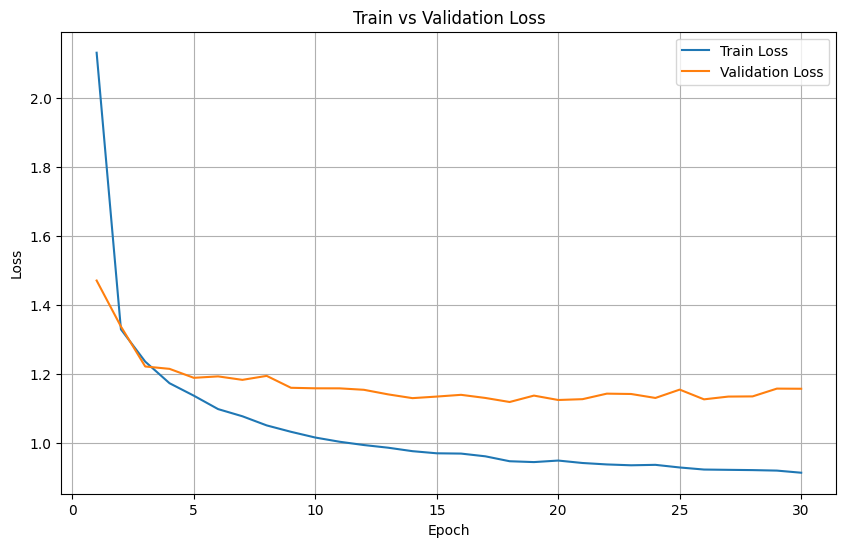

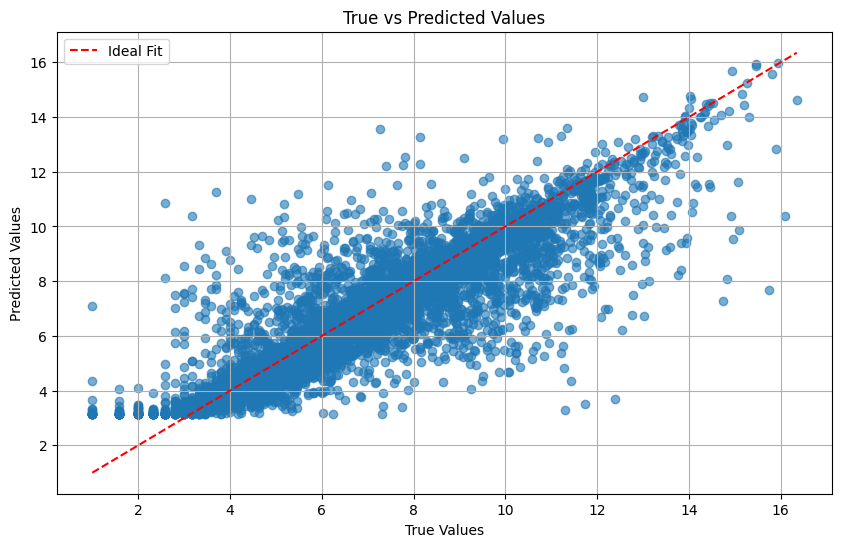

In [ ]:

# Model initialization
input_size = train_dataset[0][0].shape[0]  
model = MLP(input_size)

# Loss and Optimizer
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Track Losses
train_losses = []
val_losses = []

# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(inputs).squeeze()
        loss =torch.sqrt(criterion(predictions, targets)) # RMSE Loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_dataloader)  # Average train loss
    train_losses.append(train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in validation_dataloader:
            val_predictions = model(val_inputs).squeeze()
            val_loss += torch.sqrt(criterion(val_predictions, val_targets)).item() # RMSE Loss

    val_loss /= len(validation_dataloader)  # Average validation loss
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    #print only train loss
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")

# Save Model
torch.save(model.state_dict(), "mlp_model.pth")

# Plot Train vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Analyze Predictions: True vs Predicted
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in validation_dataloader:
        predictions = model(inputs).squeeze()
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Scatter Plot for True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.6)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#pre process test data

In [288]:

# Load data
test_combined = pd.read_csv("../data/X_test_highlevel_features_5.csv", header=None)


test_combined = (test_combined - train_mean) / train_std

# Save results
test_combined.to_csv("../data/test_highlevel_normalized.csv", index=False, header=False)



In [294]:
# load test data
test_clip = "../data/test_clip_features.csv"
test_high_level = "../data/test_highlevel_normalized.csv"
test_xgb_pred_path = "../data/xgb_pred_test.csv"
create_mlp_input_files(test_clip, test_xgb_pred_path, "../data/test_combined.csv")
combined_path = "../data/test_combined.csv"
create_mlp_input_files(combined_path, test_high_level, "../data/test_combined_2.csv")

In [295]:
test_input_path = "../data/test_combined_2.csv"
test_target_path = "../data/y_test.csv"

test_dataset = CSVInputTargetDataset(test_input_path, test_target_path)
mean_, std_ = test_dataset.normalize(mean, std)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

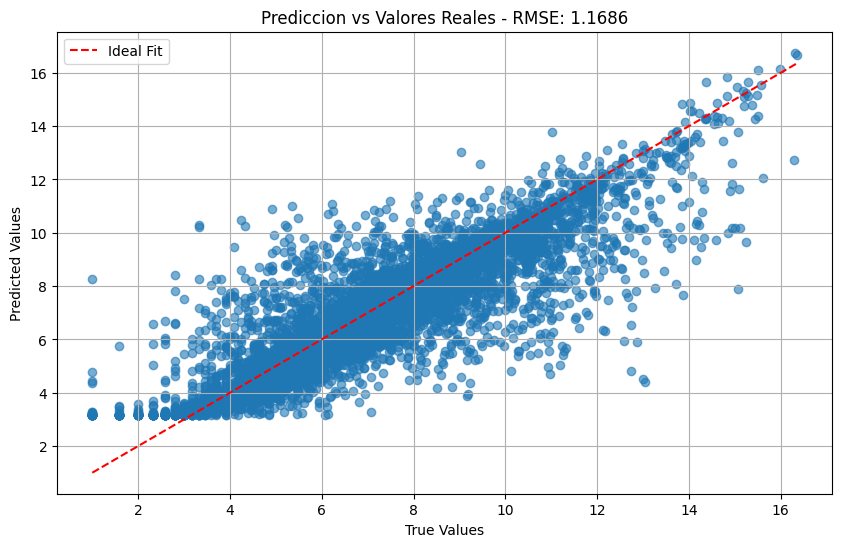

Test RMSE: 1.1686


In [296]:
# Analyze Predictions: True vs Predicted and calculate RMSE
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        predictions = model(inputs).squeeze()
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

rmse = torch.sqrt(criterion(torch.tensor(all_preds), torch.tensor(all_targets)))


# Scatter Plot for True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.6)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f'Prediccion vs Valores Reales - RMSE: {rmse:.4f}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Test RMSE: {rmse:.4f}")


/var/folders/7f/w8t6fsgd78gfxd_lgh6918b00000gn/T/ipykernel_67757/880779669.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Media: {mean_error:.2f}\Varianza: {var_error:.2f}', loc='upper right')


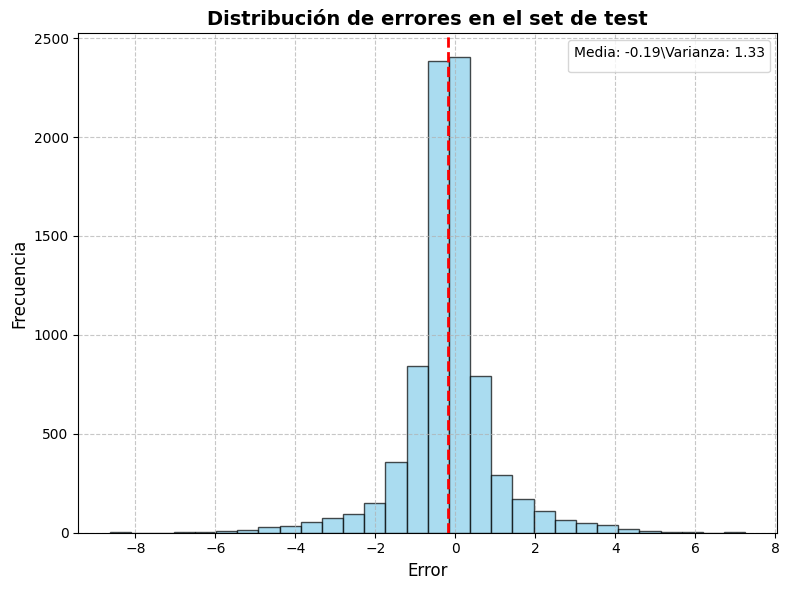

In [300]:
import numpy as np
def plot_error_distribution(y_pred_test, y_test):

    errors = []
    for pred, true in zip(y_pred_test, y_test):
        errors.append(pred - true)

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    var_error = np.var(errors)

    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2)

    plt.title('Distribución de errores en el set de test', fontsize=14, weight='bold')
    plt.xlabel('Error', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    plt.legend(title=f'Media: {mean_error:.2f}\Varianza: {var_error:.2f}', loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('white')

    plt.tight_layout()
    plt.show()

plot_error_distribution(all_preds, all_targets)